# Analyse Experiment Data 3

With pressure sensor parascientific and new speaer 

In [15]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
config = {}

In [17]:
config['datapath_femto'] = "/home/andbro/Documents/ROMY/Scripps_Fiber/data/experiments2/"

## read data stream using obspy routine
st = obs.read(config['datapath_femto']+"munki1.263.264.css.wfdisc", format="CSS")

## merge traces that might be split due to data gaps or overlaps
st.merge()

## setting the calibration variable if not already set
st[0].stats.calib = 1.0

## show all traces in data stream
st

FileNotFoundError: [Errno 2] No such file or directory: '/home/andbro/Documents/ROMY/Scripps_Fiber/data/experiments2/munki1.263.264.css.wfdisc'

In [18]:
st.plot(equal_scale=False);

NameError: name 'st' is not defined

## Experiment Valve Open

Read pressure data

In [19]:
config['datapath_pressure'] = "/home/andbro/Documents/ROMY/Scripps_Fiber/data/pressure/"

In [20]:
## read data of parascientific barometer
pressure = pd.read_csv(config['datapath_pressure']+"DATA3.txt", names=["timestamp","pressure"])

## convert timestamp to datetime objects
pressure['timestamp'] = pd.to_datetime(pressure.timestamp)

## make local time to UTC (+7 hours)
pressure['timestamp'] += pd.to_timedelta(7, unit='h')

## resample with df=1sec
pressure = pressure.resample("1S", on="timestamp").mean().reset_index()

pressure

,timestamp,pressure
0,2022-09-20 17:19:43,101.081950
1,2022-09-20 17:19:44,101.324000
2,2022-09-20 17:19:45,101.401933
3,2022-09-20 17:19:46,101.223550
4,2022-09-20 17:19:47,100.875000
...,...,...
32487,2022-09-21 02:21:10,100.810000
32488,2022-09-21 02:21:11,101.139600
32489,2022-09-21 02:21:12,101.263000
32490,2022-09-21 02:21:13,101.160700


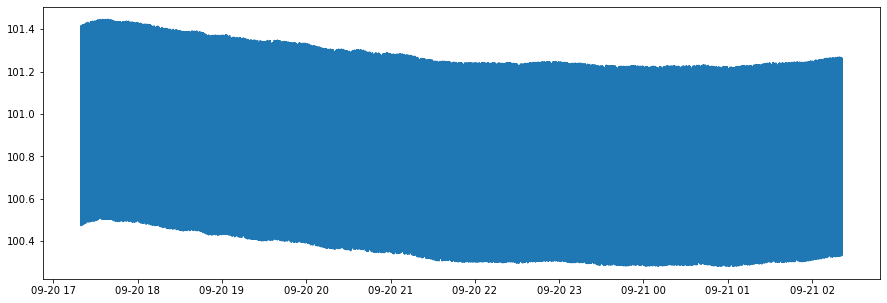

In [6]:
plt.figure(figsize=(15,5))
plt.plot(pressure.timestamp, pressure.pressure)

In [7]:
pressure_trace = obs.Trace()

pressure_trace.data = np.array(pressure.pressure)
pressure_trace.stats.starttime = obs.UTCDateTime(pressure.timestamp[0])
pressure_trace.stats.delta = 1.0
pressure_trace.stats.station = "BARO"
pressure_trace.stats.channel = "XXX"

pressure_trace

.BARO..XXX | 2022-09-20T17:19:43.000000Z - 2022-09-21T02:21:14.000000Z | 1.0 Hz, 32492 samples

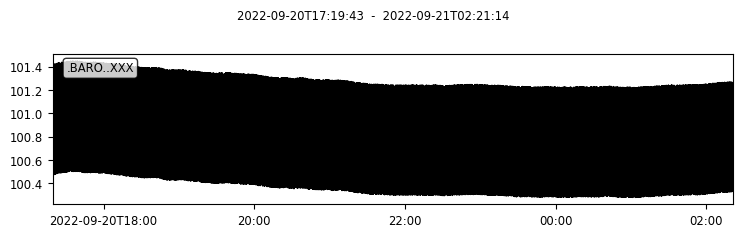

In [8]:
pressure_trace.plot();

Text(0, 0.5, 'Pressure (kPa)')

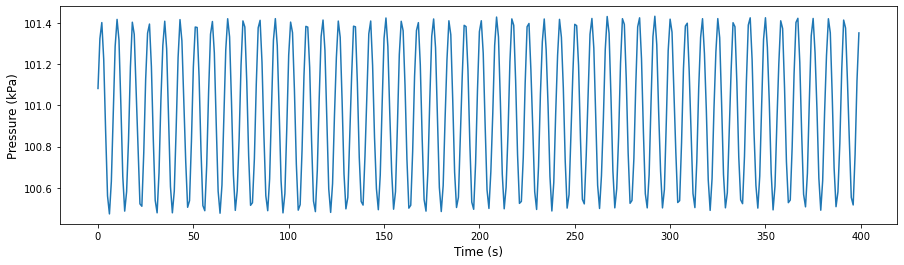

In [9]:
plt.figure(figsize=(15,4))
plt.plot(pressure_trace.data[:400])
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Pressure (kPa)", fontsize=12)

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


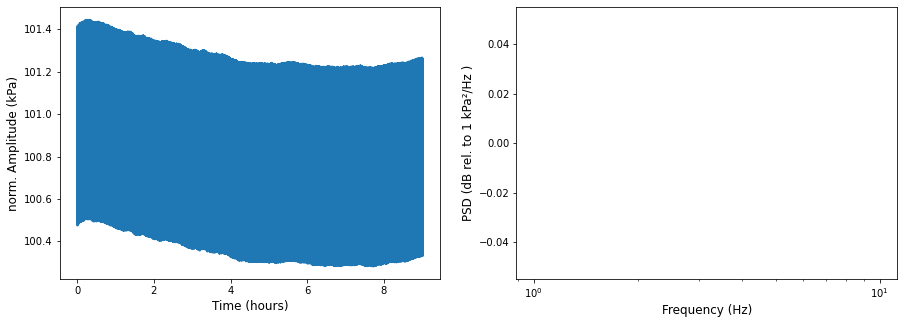

In [10]:
def __plot_psd(trace):

    from scipy.signal import welch, hann


    signal = trace.data 
    
    nblock =  512
    overlap = None
    # window = hann(int(nblock))

    f, Pxx = welch(signal, fs=trace.stats.sampling_rate, 
                    window='hann', noverlap=overlap, nperseg=nblock,
                    scaling="density",
                    return_onesided=True)

    ## normalize
    # Pxx /= nblock

    
    Pxx /= max(Pxx)
    Pxx = 10*np.log10(Pxx)

    
    ## ------------------------

    font = 12

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    tx = np.linspace(0, trace.stats.npts/trace.stats.sampling_rate/3600, trace.stats.npts)
    ax[0].plot(tx, signal)

    ax[1].vlines(0.120, min(Pxx), max(Pxx), color="grey", ls="--", alpha=1, zorder=0)
    ax[1].semilogx(f, Pxx)

#     ax[1].set_ylim(-80,5)
#     ax[1].set_xlim(1e-3,5)

    ax[0].set_xlabel("Time (hours)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_ylabel("norm. Amplitude (kPa)", fontsize=font)
    ax[1].set_ylabel("PSD (dB rel. to 1 kPa²/Hz )", fontsize=font)

    plt.show();
    
__plot_psd(pressure_trace)

In [11]:
st2 = st.copy()

t1 = obs.UTCDateTime("2022-09-20 18:20")
t2 = obs.UTCDateTime("2022-09-21 02:20")

st2.trim(t1, t2)

# st2.plot(equal_scale=False);


## add pressure trace
st2 += pressure_trace


def __make_plot_traces():

    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)

    fig.subplots_adjust(hspace=0)

    ax[0].plot(st2.select(station="BARO")[0].times()/3600, st2.select(station="BARO")[0].data)
    ax[1].plot(st2.select(station="munki1")[0].times()/3600, st2.select(station="munki1")[0].data)

    plt.xlabel("Time (hours)", fontsize=12)
    ax[0].set_ylabel("Pressure (kPa)", fontsize=12)
    ax[1].set_ylabel("Phase (rad)", fontsize=12)

__make_plot_traces()

NameError: name 'st' is not defined

In [ ]:

# st2.detrend('polynomial', order=2)

# st2.taper(0.1)
# st2.filter('highpass', freq=0.1, corners=4, zerophase=True)

# st2.plot(equal_scale=False);

In [ ]:
def __plot_psd(trace):

    from scipy.signal import welch, hann


    signal = trace.data

    signal = [el if not np.isnan(el) else 0 for el in signal ]
    
    tstart = trace.stats.starttime
    
    nblock =  512 *20
    overlap = None
    # window = hann(int(nblock))

    f, Pxx = welch(signal, fs=trace.stats.sampling_rate, 
                    window='hann', noverlap=overlap, nperseg=nblock,
                    scaling="density",
                    return_onesided=True)
    ## normalize
    # Pxx /= nblock

    Pxx /= max(Pxx)
    Pxx = 10*np.log10(Pxx)


    ## ------------------------

    font = 12

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    tx = np.linspace(0, trace.stats.npts/trace.stats.sampling_rate/3600, trace.stats.npts)
    ax[0].plot(tx, signal)

    ax[1].vlines(0.120, min(Pxx), max(Pxx), color="grey", ls="-", alpha=0.8, zorder=0)
    ax[1].plot(f, Pxx)

    
    ax[1].set_xscale("log")
    ax[1].set_ylim(-80,0)
    ax[1].set_xlim(1e-2,1)

    ax[0].set_xlabel(f"Time from {tstart.date} {str(tstart.time)[:8]} UTC (hours)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_ylabel("Phase (rad)", fontsize=font)
    ax[1].set_ylabel("PSD (dB rel. to 1 rad²/Hz )", fontsize=font)

    plt.show();
    
__plot_psd(st2.select(station="munki1")[0])
__plot_psd(st2.select(station="BARO")[0])

In [13]:
from andbro__get_mean_amplitude import __get_mean_amplitude

signal = pressure_trace.data

amps, amps_mean, amps_std = __get_mean_amplitude(signal, deltaN=100)

amps_mean, amps_std

(0.94057710905349778, 0.002244286644106197)